In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

2022-10-02 16:31:41.703708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-02 16:31:41.830705: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/marian/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow version: 2.10.0


In [2]:
#best 32, 32, 256, 256, 12, 256 / 180min
batch_size = 32
seq_len = 32

d_k = 394
d_v = 394
n_heads = 12
ff_dim = 394

In [3]:
df = pd.read_csv('data/bitstampUSD180minOHLC.csv')

In [4]:
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 

In [5]:
# Apply moving average with a window of 10 days to all columns
#df[['O56', 'H56', 'L56', 'C56', 'V56']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(56).mean()
#df[['O112', 'H112', 'L112', 'C112', 'V112']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(112).mean()
#df[['O168', 'H168', 'L168', 'C168', 'V168']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(168).mean()
df['sMA'] = df.Close.rolling(window=60).mean()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(30).mean()
df.dropna(how='any', axis=0, inplace=True)
df = df.iloc[:, [0,1,2,3,4,6,5]]
df.head()

,timestamp,Open,High,Low,Close,sMA,Volume
59,2016-01-08 09:00:00,439.180333,441.548000,437.240333,439.981000,435.912833,1121.790093
60,2016-01-08 12:00:00,439.902000,442.241667,437.983000,440.704000,436.340333,1090.510292
61,2016-01-08 15:00:00,440.641333,442.941667,438.486667,441.165000,436.550333,1148.638178
62,2016-01-08 18:00:00,441.130667,443.474333,438.881000,441.742333,436.838167,1185.153814
63,2016-01-08 21:00:00,441.702667,444.102000,439.458333,442.384333,437.171167,1195.353776


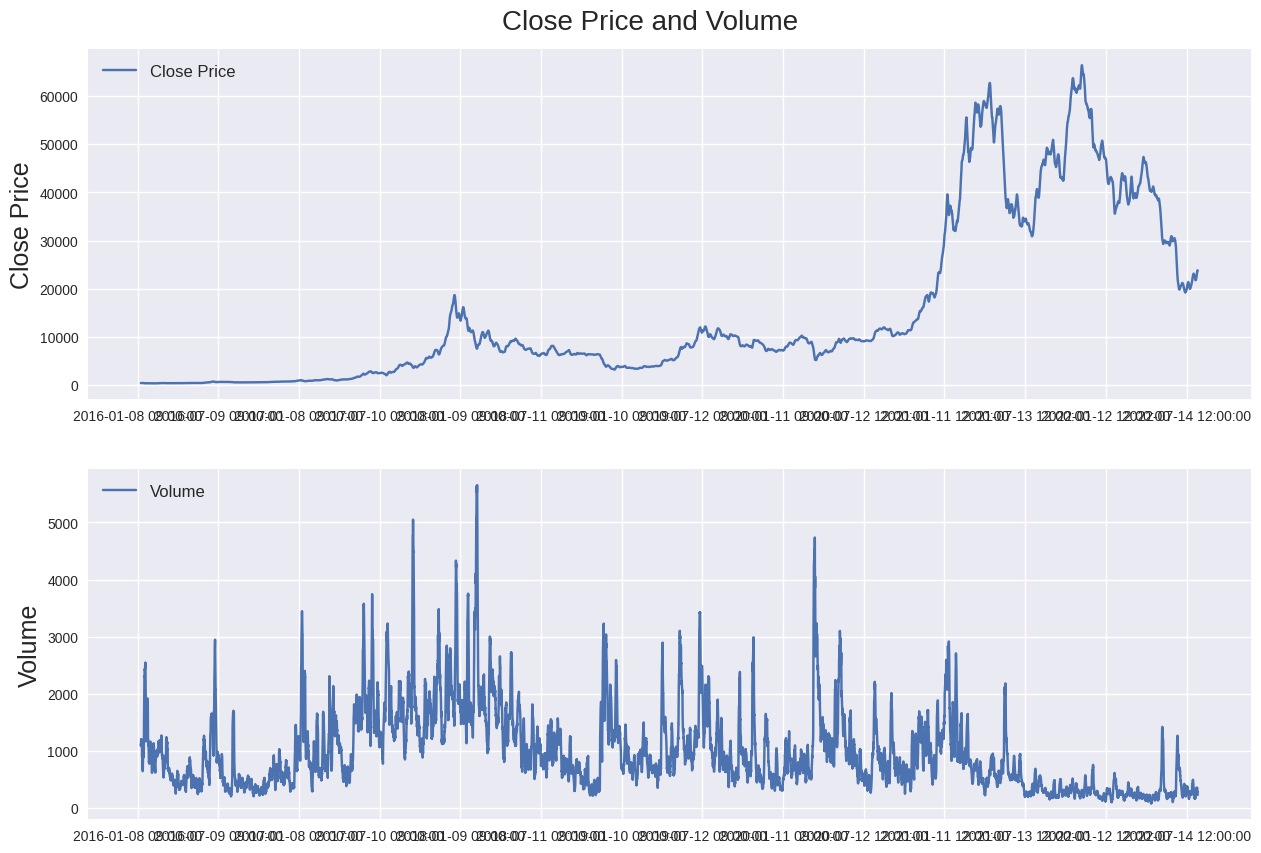

In [6]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['timestamp'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['timestamp'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [7]:


'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['sMA'] = df['sMA'].pct_change()
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.4*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close', 'sMA']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close', 'sMA']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)
df['sMA'] = (df['sMA'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['timestamp'], inplace=True)
df_val.drop(columns=['timestamp'], inplace=True)
df_test.drop(columns=['timestamp'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (11505, 6)
Validation data shape: (3835, 6)
Test data shape: (3835, 6)


,Open,High,Low,Close,sMA,Volume
60,0.543630,0.542631,0.544395,0.543631,0.534467,0.294448
61,0.544148,0.542795,0.536808,0.535371,0.527559,0.354512
62,0.536262,0.537536,0.533341,0.539003,0.530022,0.338596
63,0.538837,0.540478,0.539097,0.541004,0.531446,0.321444
64,0.540296,0.541686,0.540867,0.540589,0.532603,0.319676


In [8]:
df_train.describe()

,Open,High,Low,Close,sMA,Volume
count,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000
mean,0.524304,0.524301,0.524306,0.524301,0.524300,0.315667
std,0.035772,0.035170,0.037110,0.035771,0.025683,0.032229
min,0.342314,0.372486,0.000000,0.343512,0.391705,0.000000
25%,0.508422,0.507830,0.508684,0.508408,0.512056,0.300780
50%,0.524229,0.523747,0.524866,0.524251,0.522934,0.315037
75%,0.541564,0.540913,0.542419,0.541489,0.537934,0.328163
max,0.709938,0.706866,1.000000,0.709935,0.658316,1.000000


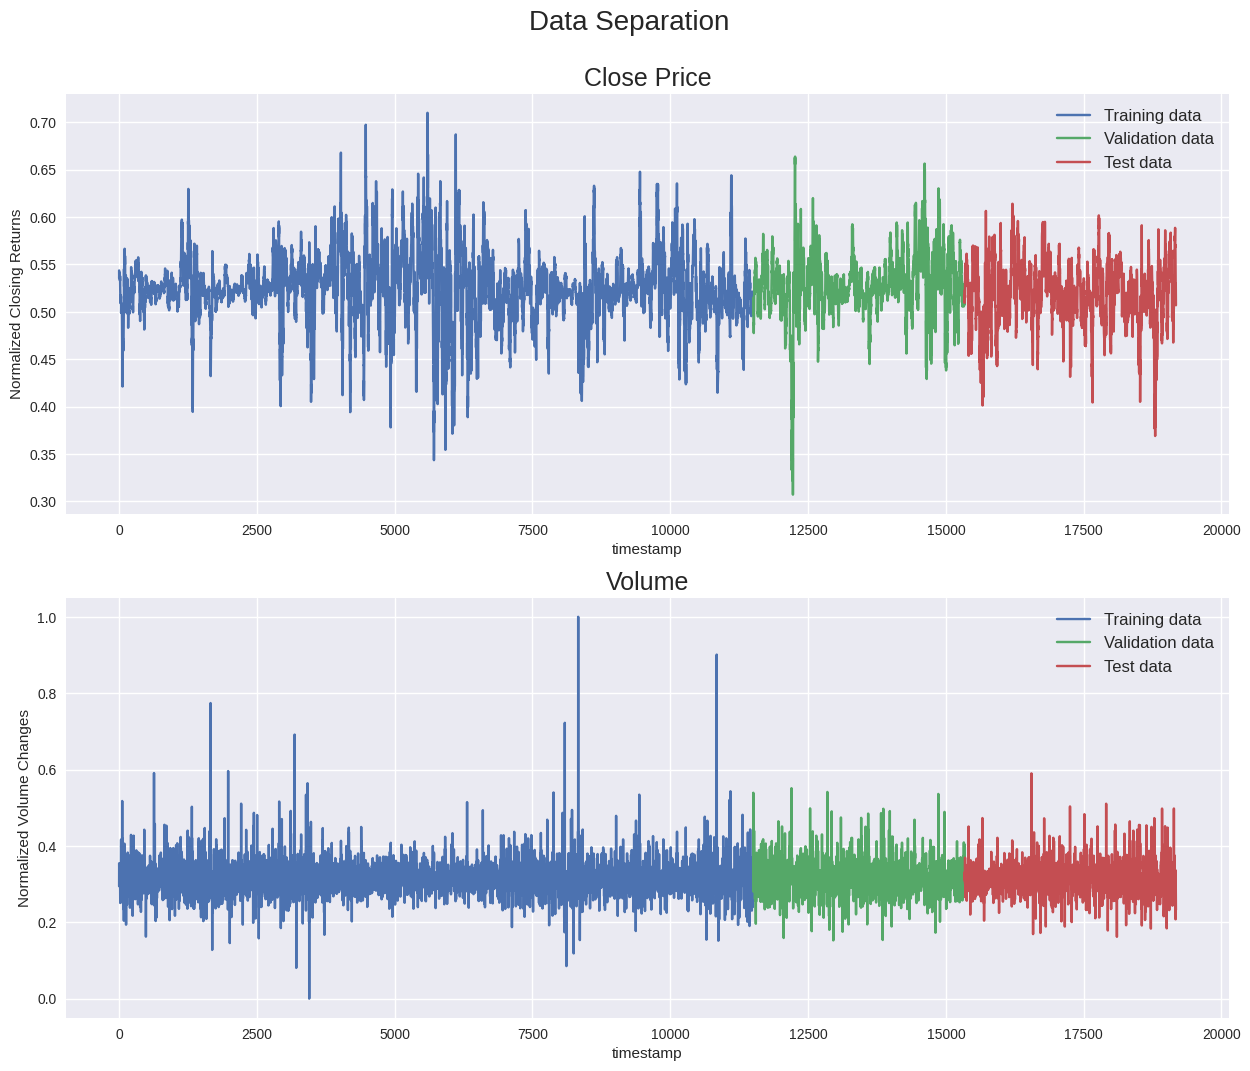

In [9]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('timestamp')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('timestamp')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [10]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11473, 32, 6) (11473,)
(3803, 32, 6) (3803,)


In [11]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:, :, :5], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear  # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1)  # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)  # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1)  # shape = (batch, seq_len, 2)

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [12]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

In [13]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

            # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [14]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config

In [15]:
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, X_train.shape[2]))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    mae = tf.keras.losses.MeanAbsoluteError()
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    opt = tf.keras.optimizers.Adam(learning_rate=0.00000729735256)
    opt2 = tf.keras.optimizers.Adadelta()
    model.compile(loss=mape, optimizer=opt, metrics=['mae', 'mape'])
    return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer_TimeEmbedding_ma.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True,
                                              verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))


2022-10-02 16:31:43.668391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 16:31:43.671547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 16:31:43.671720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 16:31:43.672087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 6)]      0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 32, 2)        128         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 32, 8)        0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 32, 8)       172226      ['concatenate[0][0]',        

2022-10-02 16:31:59.742081: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-02 16:32:00.054089: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


359/359 [==============================] - ETA: 0s - loss: 98.3191 - mae: 0.5155 - mape: 98.3191
Epoch 1: val_loss improved from inf to 96.35767, saving model to Transformer_TimeEmbedding_ma.hdf5
359/359 [==============================] - 106s 255ms/step - loss: 98.3191 - mae: 0.5155 - mape: 98.3191 - val_loss: 96.3577 - val_mae: 0.5095 - val_mape: 96.3577
Epoch 2/35
359/359 [==============================] - ETA: 0s - loss: 92.6658 - mae: 0.4860 - mape: 92.6658
Epoch 2: val_loss improved from 96.35767 to 89.77561, saving model to Transformer_TimeEmbedding_ma.hdf5
359/359 [==============================] - 89s 249ms/step - loss: 92.6658 - mae: 0.4860 - mape: 92.6658 - val_loss: 89.7756 - val_mae: 0.4749 - val_mape: 89.7756
Epoch 3/35
359/359 [==============================] - ETA: 0s - loss: 83.2885 - mae: 0.4371 - mape: 83.2885
Epoch 3: val_loss improved from 89.77561 to 80.28851, saving model to Transformer_TimeEmbedding_ma.hdf5
359/359 [==============================] - 90s 250ms/st

In [16]:
model = tf.keras.models.load_model('Transformer_TimeEmbedding_ma.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

119/119 [==============================] - 8s 63ms/step
 
Evaluation metrics
Training Data - Loss: 3.6756, MAE: 0.0193, MAPE: 3.6756
Validation Data - Loss: 3.6282, MAE: 0.0191, MAPE: 3.6282
Test Data - Loss: 3.9157, MAE: 0.0200, MAPE: 3.9157


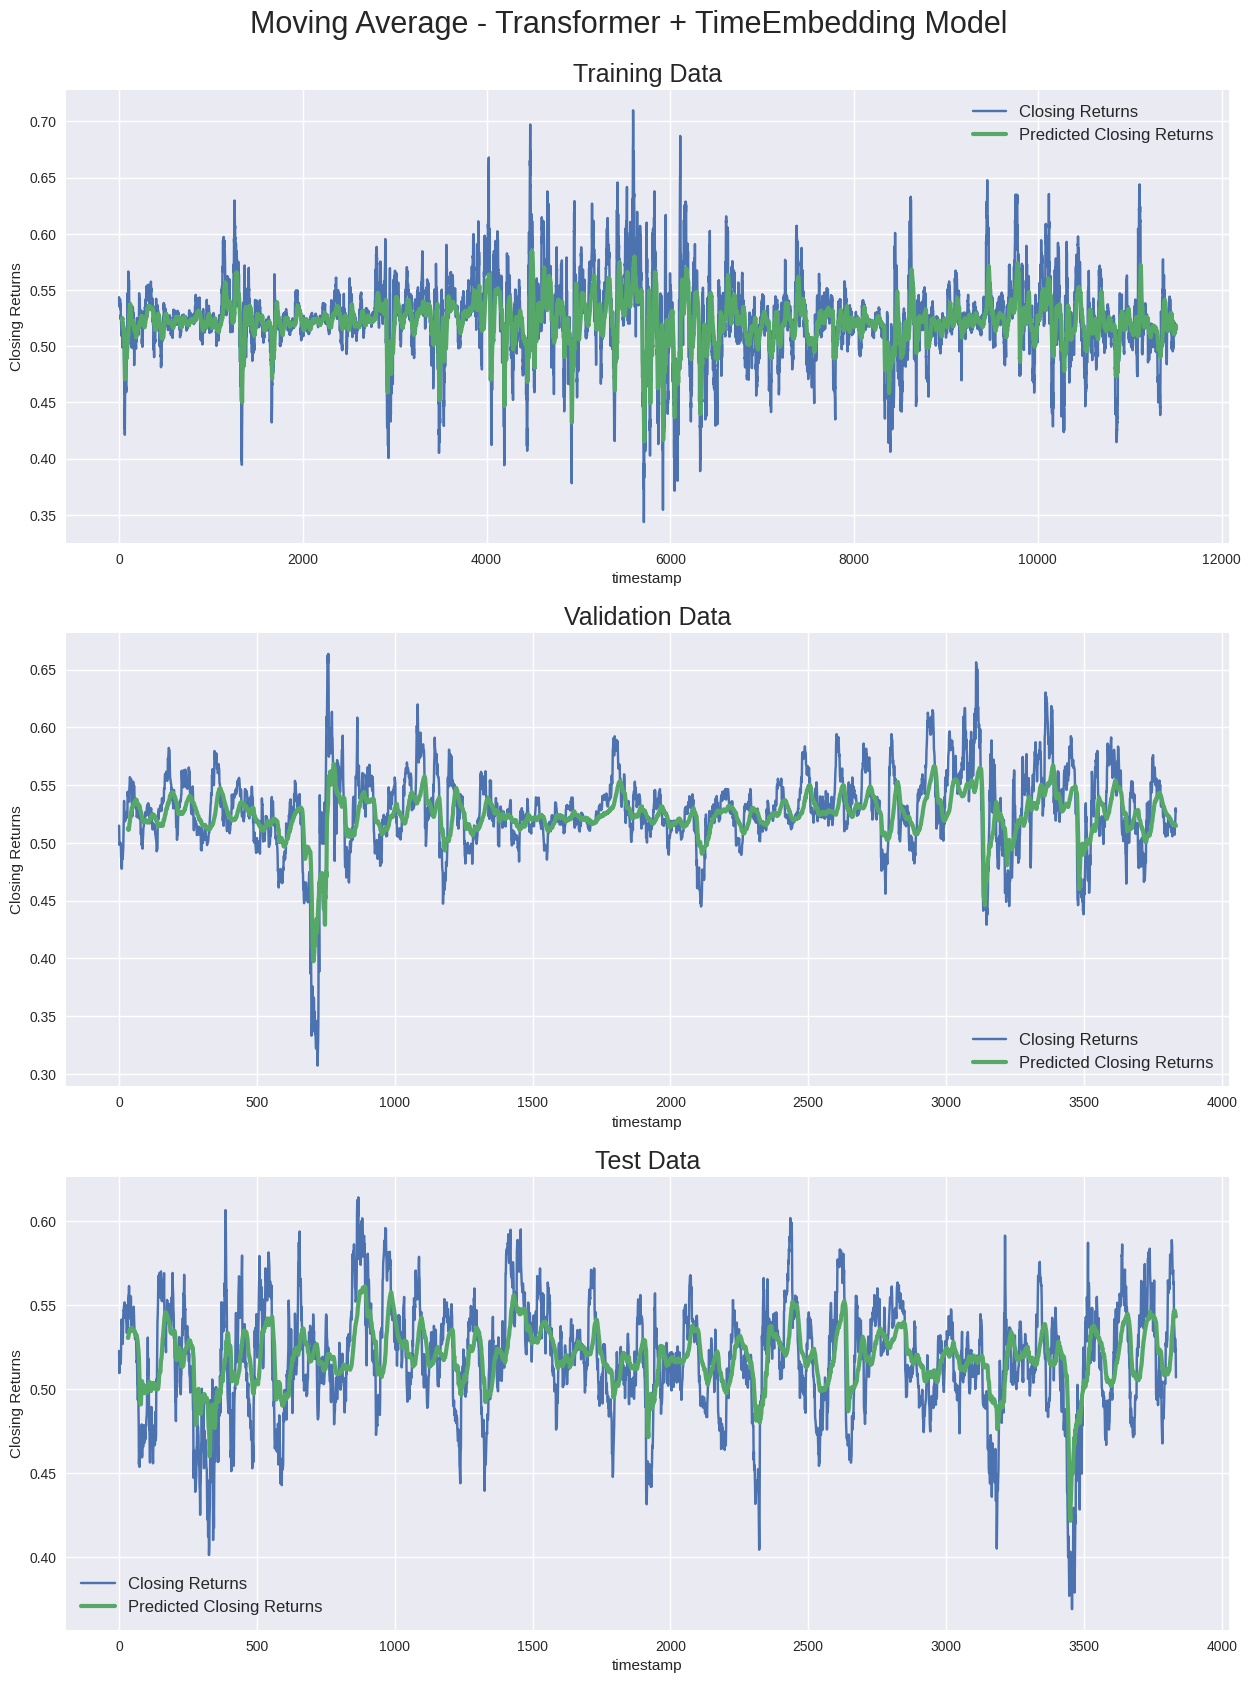

In [17]:
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('timestamp')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('timestamp')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('timestamp')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)


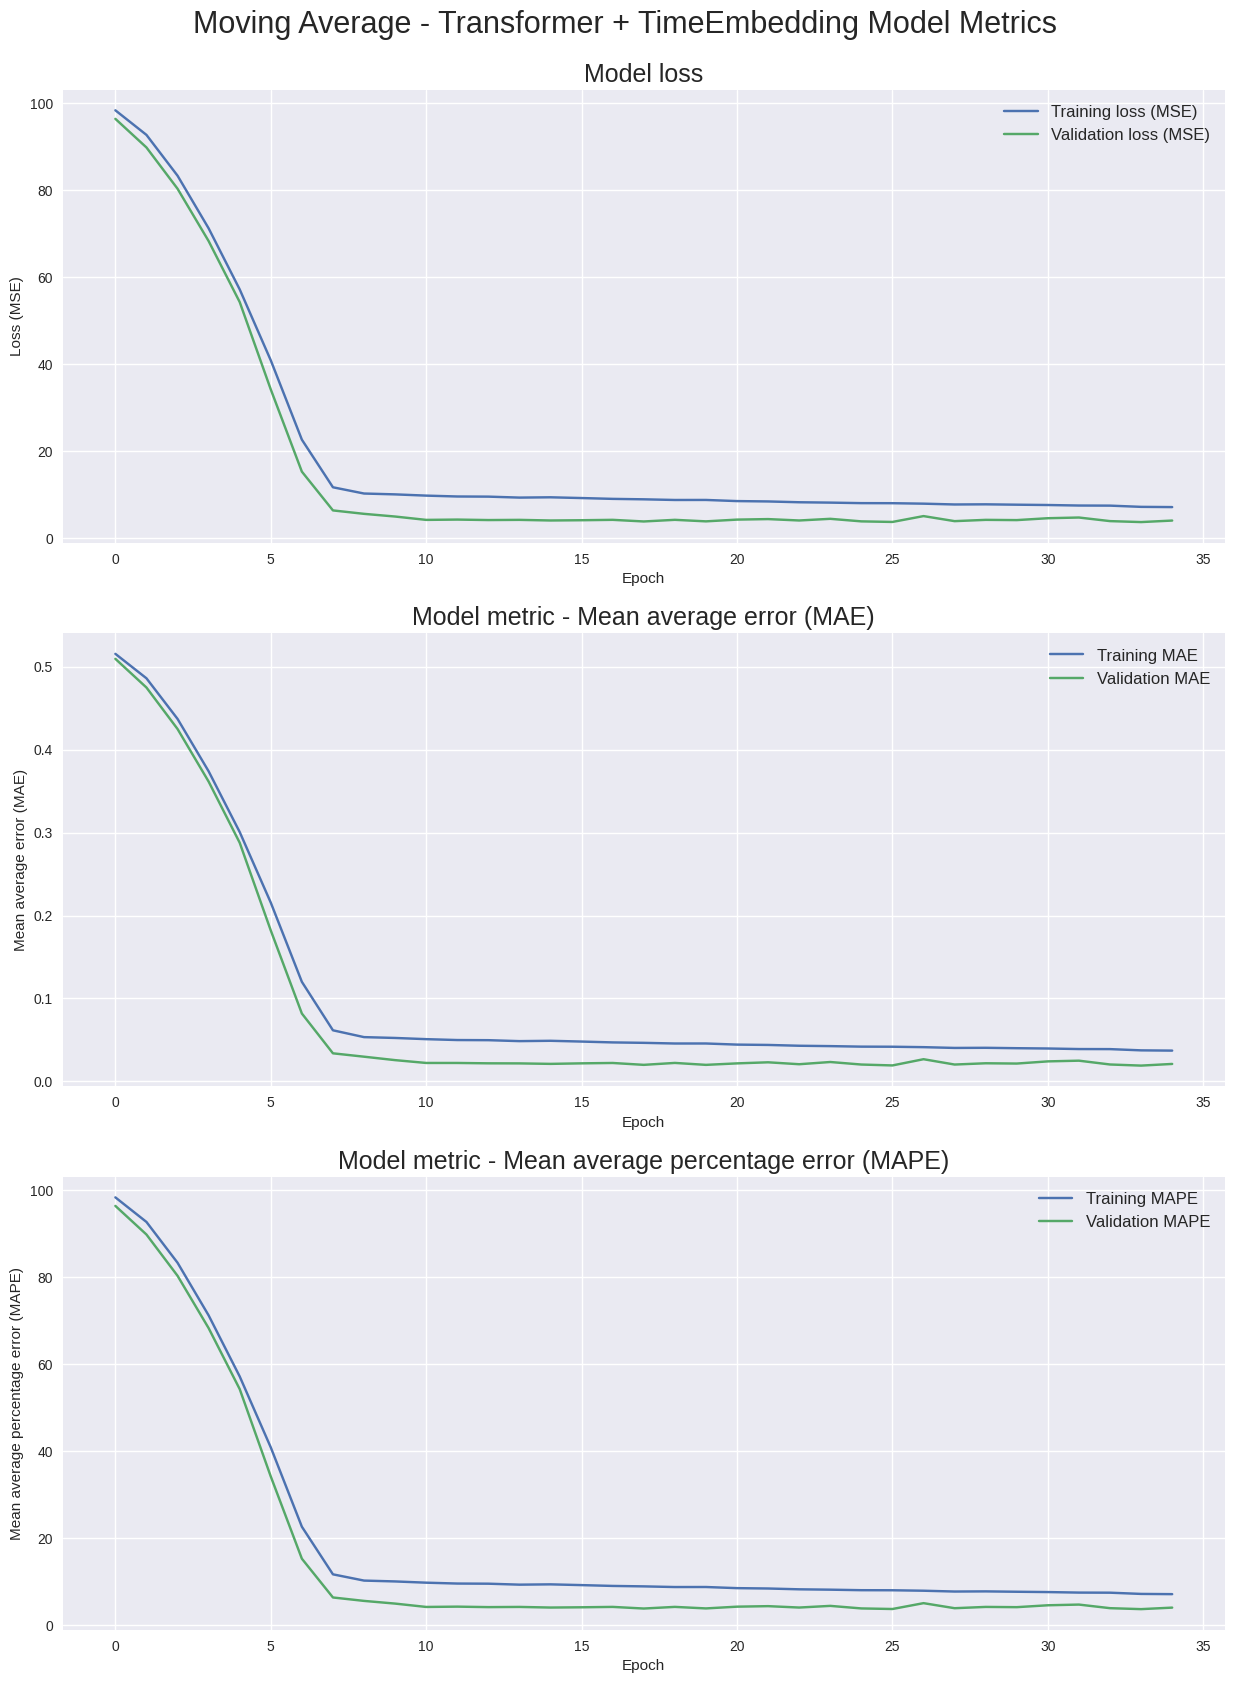

In [18]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)


In [19]:
bad = 0
good = 0
for i in range(len(test_pred)):
    if i > 0:
        if test_data[:, 3][i] >= test_data[:, 3][i-1] and test_pred[i] >= test_pred[i-1]:
            good += 1
        elif test_data[:, 3][i] < test_data[:, 3][i-1] and test_pred[i] < test_pred[i-1]:
            good += 1
        else:
            bad += 1
print('good:', good, 'bad:', bad)


good: 1849 bad: 1953
